# **Tutorial 1. Dealing with bigWig Data**

BigWig files are compressed binary files developed by UCSC. They are primarily used in bioinformatics to store and visualise genomic data in UCSC's Genome Browser. The files are indexed allowing access to specific genomic regions without having to access or download the whole genome. Accessing and converting their data for machine learning purposes can be quite confusing at times. UCSC has their own programs to extract genomic data from bigWigs, however python libraries like pyBigWig also exist, making converting bigWigs to numpy arrays much easier. 

This tutorial begins using UCSC's programs to quickly understand the genomic data within BigWigs, before using the pyBigWig library to simply extract BigWig data. 

The final part of this tutorial uses the pyBigWig library to load, filter, and split BigWig data into training, validation, and test sets. The data consists of signal p-values from ChIP-seq experiments, processed using the MACS2 tool, which outputs signal averaged over 25 base pair bins. We will re-average these signals to a resolution of 32 base pairs (based on model requirements). Additionally, we will implement threshold-based filtering and consistent data splits to ready the data for a model.

This tutorial uses ChIP-seq histone data from two experiments from the Encode project with accession ids: <br>
[ENCSR817LUF](https://www.encodeproject.org/experiments/ENCSR817LUF/) <br>
[ENCSR958TSO](https://www.encodeproject.org/experiments/ENCSR958TSO/)

Note: <br>
This tutorial is hosted by [mybinder.org](mybinder.org) to provide an interactive experience. Due to computational limitations, especially with regards to machine learning models, genomic data is accessed via url. Furthermore, this tutorial only uses data on one chromosome. When training models in a real-world setting, it is recommended that bigWigs be downloaded locally (for computational efficiency) and models are trained using multiple chromosomes depending on the model's aim.

## **UCSC Programs**

In order to get a quick sense of the data in a bigWig file, lets use UCSC's programs. <br><br>
UCSC's programs to access information from bigWigs include:

**bigWigInfo** — prints out information about a bigWig file. <br><br>
**bigWigSummary** — extracts summary information from a bigWig file. <br><br>

Additional UCSC programs include: <br> <br>
- bigWigToWig  <br><br>
- bigWigToBedGraph <br><br>
These programs allow for converting bigWig files into other formats such as .wig and .bedgraph if needed. <br><br>

Available to download from "https://genome.ucsc.edu/goldenPath/help/bigWig.html". The executable programs are within this tutorial's github repository.

Running the programs by themselves print out their help/usage statements.

In [18]:
#bigWigInfomac (mac environment)
#bigWigInfo (linux - binder/online environment)

#!./bigWigInfo
#!./bigWigSummary

## bigWigInfo
**BigWig files (.bw) can be accessed via url**. For example, if you look at genomic data from the [Encode Project](https://www.encodeproject.org), processed data such as p-values and fold-change data are in bigWig format. The bigWig file is available to be downloaded or accessed from "https://www.encodeproject.org/files/[experiment]/@@download/[experiment].bigWig", where [experiment] is the accession id of the experiment. We can parse the indexed data without having to download the files themselves.

Take the accession id [ENCSR817LUF](https://www.encodeproject.org/experiments/ENCSR817LUF/). This is the same experiment that we visualised earlier using the UCSC Genome Browser (1.2.2 Example Data Representations:). Recall it was a ChIP-seq experiment targeting the H3K36me3 histone modification in brain tissue.

The bigWig file containing the p-value for signal strength for this experiment has the accession id [ENCFF601VTB](https://www.encodeproject.org/files/ENCFF601VTB/). The specific accession id's for bigWig files can be found in the "Association graph" or "File details" tab from any experiment ([ENCSR817LUF](https://www.encodeproject.org/experiments/ENCSR817LUF/)).
<br> <br>Lets run UCSC's programs on this bigWig.


In [51]:
!./bigWigInfo https://www.encodeproject.org/files/ENCFF601VTB/@@download/ENCFF601VTB.bigWig

#!./bigWigInfo https://www.encodeproject.org/files/ENCFF601VTB/@@download/ENCFF601VTB.bigWig -chroms

version: 4
isCompressed: yes
isSwapped: 0
primaryDataSize: 291,822,974
primaryIndexSize: 1,979,528
zoomLevels: 10
chromCount: 151
basesCovered: 3,097,173,257
mean: 0.438626
min: 0.000000
max: 203.199738
std: 1.518775


## bigWigSummary

bigWigSummary allows us to view summary statistics (-type=mean/min/max/std/coverage) from specified genomic regions within chromosomes.
This is done using "bigWigSummary -type=mean/min/max/std/coverage file.bigWig chrom start end dataPoints". The start and end positions represent the genomic coordinates we are interested in, while dataPoints are simply the number of bins we want to summarise the data into. 

Earlier using the UCSC Genome Browser (1.2.2 Example Data Representations:) we visualised the p-value signals from chromosome 1, within the region: 11,084,744 - 11,095,920. Lets summarise the mean of p-values across this genomic region into 10 bins.

In [30]:
!./bigWigSummary -type=mean https://www.encodeproject.org/files/ENCFF601VTB/@@download/ENCFF601VTB.bigWig chr1 11084744 11095920 10

0.136691	1.40258	10.3889	9.00481	7.18722	9.58774	6.65801	4.89069	5.94204	3.56829


<br>What do these bins represent? <br>
In essence, we've taken a genomic region (11,084,744 - 11,095,920) of 11,176 base pairs long, and averaged p-values over 10 bins of (11,176/10) 1,117.6 base pairs long resulting in 10 averaged p-values across the region. <br>

Potential problems: <br>
- 1,117.6 base pairs is quite a large resolution. <br>
- We need to decide what prediction resolution in base pairs we want to look at. <br>

- One way to tackle this without creating computational problems (remember, we want to look at multiple chromosomes consisting of millions of base pairs) is to take an input window e.g. 2048bps, and aim to predict the average p-value (coverage) within a smaller resolution e.g. 32bps at the center of the input window. Essentially, within this 2048bp input window, each bin (2048/32 = 64 bins) of 32bps is averaged. The max coverage is then used as the target value (Y) for this 2048bp region.

Using this example, the cell below shows what the first 2048bp input window would look like. The max coverage would be the max value across all 64, 32bps averaged bins (0.03324). So for training our model, for this region the X values are the 2048bps (one-hot-encoded as DNA) and the target value (Y) is 0.03324. Of course, however, we would need to shift this input window accross the desired region within and across chromosomes to complete the dataset.


It could also be the case that you choose to predict for the centre X base-pairs at the averaged level. For example, you could choose to predict the centre (32*6) 192 base-pairs, i.e. 6 values max coverage values. This depends on how you design your model. <br>



In [103]:
!./bigWigSummary -type=mean https://www.encodeproject.org/files/ENCFF601VTB/@@download/ENCFF601VTB.bigWig chr1 0 2048 64

# The prediction region would be the center of this input window. e.g. from 1008 to 1040. 

# The next input window would be from 2048 to 4096. 64 bins each holding 32bps would be averaged, with the maximum value chosen
# as the max coverage 

0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324	0.03324


<br><br>![Alt text](bp_resolution.png)
<br>[Jai Patel. Leveraging Genetic Diversity With
Machine Learning. MENG INDIVIDUAL PROJECT, Imperial College London.]

## USING pyBigWig

https://github.com/deeptools/pyBigWig?tab=readme-ov-file#load-the-extension

The pyBigWig python library allows for an easier experience with accessing bigWig files.

bw = **pyBigWig.open** <br>
bw **.header**  (Similar to UCSC's bigWigInfo)<br>
bw **.stats** (Similar to UCSC's bigWigSummary)<br>
bw **.values** <br>
bw **.intervals** <br>

In [4]:
import numpy as np
import pyBigWig
import matplotlib.pyplot as plt

In [96]:
bw = pyBigWig.open("https://www.encodeproject.org/files/ENCFF601VTB/@@download/ENCFF601VTB.bigWig")

# Specify values for a specific region
chrom = "chr1"
start = 11084744
end = 11095920     # Same region of ENCFF601VTB we were exploring above

# Get values for the specified interval
values = bw.values(chrom, start, end, numpy=True) # List containing one value for every base, converted to numpy array

# Using .intervals
intervals = bw.intervals(chrom, start, end)

# Header
header = bw.header()

# Stats
mean = bw.stats("chr1", start, end, type="mean")
exactmean = bw.stats("chr1", start, end, type="mean", exact=True)

# Close the BigWig file
bw.close()


In [97]:
print(header)

{'version': 4, 'nLevels': 10, 'nBasesCovered': 3097173257, 'minVal': 0, 'maxVal': 203, 'sumData': 1358500160, 'sumSquared': 7740052574}


In [98]:
print(mean)

[6.06633192567852]


In [99]:
print(np.mean(values))

5.8765645


In [100]:
print(exactmean)

[5.876564222448636]


### Summary Statistics Note

The discrepancy between stats and statstrue is due to the way in which data is accessed in bigWig files. As they were created for genome browsers, the speed of visualising large amounts of data is important versus exact statistics. Summary statistics are affected by the zoom levels or 'nlevels'. When using numpy or the 'exact=True' tag to calculate the mean, the results are exact.

"When a bigWig file is queried for a summary statistic, the size of the interval is used to determine whether to use a zoom level and, if so, which one. The optimal zoom level is that which has the largest bins no more than half the width of the desired interval. If no such zoom level exists, the original intervals are instead used for the calculation." [pybigwig](https://github.com/deeptools/pyBigWig?tab=readme-ov-file#a-note-on-statistics-and-zoom-levels)

### Comparing Values vs Intervals

In [101]:
print("The shape of the values data is:", values.shape)

intervals = np.array(intervals)
print("The shape of the interval data is:", intervals.shape)


The shape of the values data is: (11176,)
The shape of the interval data is: (651, 3)


In [102]:
print("Values Data \n")
print(values[0:5])


print("\nIntervals Data \n")
# Print the start position, end position, and value for each interval
for interval in intervals[0:5]:
    print(f"Start: {interval[0]}, End: {interval[1]}, Value: {interval[2]}")


Values Data 

[0.13422 0.13422 0.13422 0.13422 0.13422]

Intervals Data 

Start: 11084717.0, End: 11085202.0, Value: 0.13422000408172607
Start: 11085202.0, End: 11085214.0, Value: 0.033240001648664474
Start: 11085214.0, End: 11085679.0, Value: 0.13422000408172607
Start: 11085679.0, End: 11085688.0, Value: 0.5755599737167358
Start: 11085688.0, End: 11085894.0, Value: 0.13422000408172607


<br>

The 'values data' represents every data point in the selected genomic region.

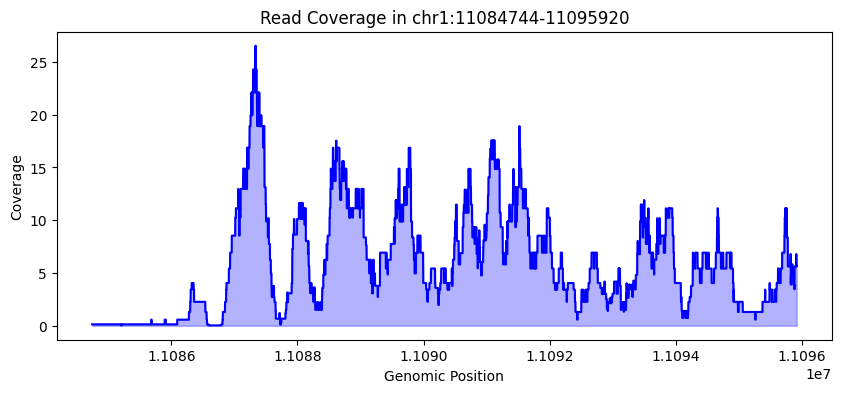

In [12]:
# Plotting the p-value data
plt.figure(figsize=(10, 4))
plt.plot(range(start, end), values, color='blue')
plt.fill_between(range(start, end), values, color='blue', alpha=0.3)
plt.title(f"Read Coverage in {chrom}:{start}-{end}")
plt.xlabel("Genomic Position")
plt.ylabel("Coverage")
plt.show()

## Combining multiple bigWig datasets


In [13]:
# URLs of the BigWig files
urls = [
    'https://www.encodeproject.org/files/ENCFF601VTB/@@download/ENCFF601VTB.bigWig',
    'https://www.encodeproject.org/files/ENCFF042SAY/@@download/ENCFF042SAY.bigWig'
]

bigwig_data = {}
for url in urls:
    bw = pyBigWig.open(url)
    if bw is not None:
        bigwig_data[url] = bw

In [14]:
def load_x(data: dict,
           labels: list,
           selected_chromosome: str,
           window_start: int,
           window_size: int = 2048,
           handle_nan: bool = True,
           arcsinh_trans: bool = True):
    """
    Function to load X data (input features) from bigwig files and optionally apply arcsinh transformation.

    Parameters:
    data (dict): Dictionary containing pyBigWig objects.
    labels (list): List of labels (keys) to extract data from `data`.
    selected_chromosome (str): Chromosome from which to load the data.
    window_start (int): Start position of the window.
    window_size (int): Size of the window, default is 2048.
    handle_nan (bool): Whether to handle NaN values by replacing them with 0, default is True.
    arcsinh_trans (bool): Whether to apply arcsinh transformation to the data, default is False.

    Returns:
    np.ndarray: Array of shape (window_size, len(labels)) with loaded data.
    """
    # Initialize the output array
    all_x = np.zeros(shape=(window_size, len(labels)))
    
    # Loop over each label and extract data
    for i, label in enumerate(labels):
        try:
            values = data[label].values(
                selected_chromosome,
                window_start,
                window_start + window_size,
                numpy=True
            )
            if handle_nan:
                values = np.nan_to_num(values)
            if arcsinh_trans:
                values = np.arcsinh(values)
            all_x[:, i] = values
        except Exception as e:
            print(f"Error loading data for label {label} on {selected_chromosome}:{window_start}-{window_start + window_size}")
            print(e)
            all_x[:, i] = np.nan 
    
    return all_x

In [15]:
#Main

In [16]:
# Define genomic region of interest
chrom = 'chr1'
start = 11084744
end = 11095920
window_size = end - start
#target_bp = 32
#pred_res = 32
labels = urls

data = load_x(bigwig_data, labels, chrom, start, window_size, arcsinh_trans=False)

print(data)
print(data.shape)

[[0.13422    1.58932996]
 [0.13422    1.58932996]
 [0.13422    1.58932996]
 ...
 [5.6262598  6.16271019]
 [5.6262598  6.16271019]
 [5.6262598  6.16271019]]
(11176, 2)


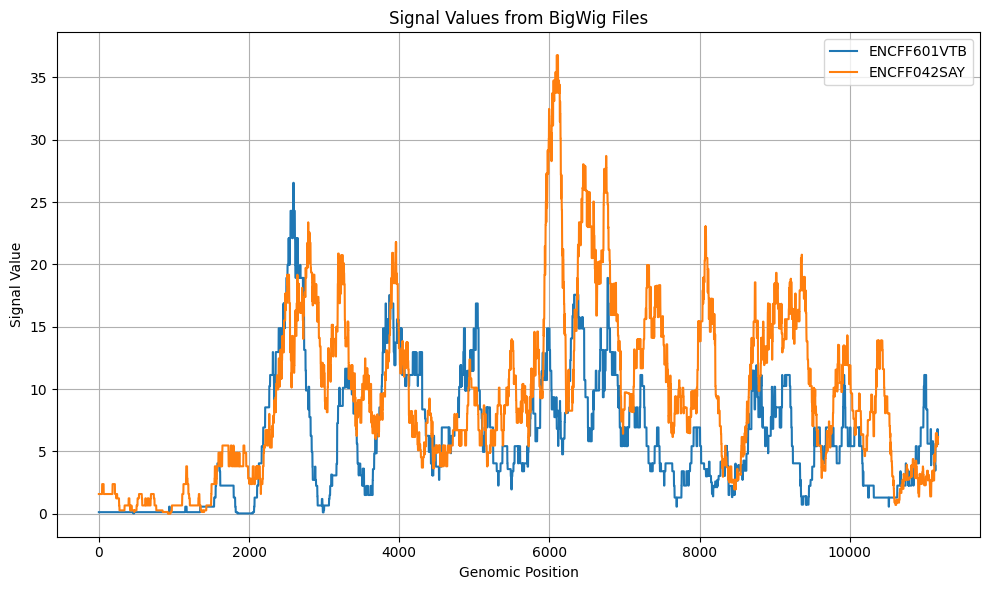

In [17]:
# Plotting the Data
labelname=[url.split('/')[-1].split('.')[0] for url in urls]

plt.figure(figsize=(10, 6))
for i, label in enumerate(labels):
    plt.plot(data[:, i], label=labelname[i])

plt.xlabel('Genomic Position')
plt.ylabel('Signal Value')
plt.title('Signal Values from BigWig Files')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()